# Rohin's Attempt lol - for the 3 cluster cases

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import multivariate_normal as mvn

from scipy.stats import norm

from math import floor
from math import log

from KNN import KNN

## Generate Points

Generate X values

In [2]:
m = 102 # Number of samples (MAKE THIS A MULTIPLE OF 3)

knownvals = [int(j*m/3) for j in range(3)] # Points for which we know the value of the label

centers = [[0,0],[1,0],[1,1]]
covar = 0.01*np.identity(2)

X = mvn(centers[0],covar, int(m/3))
X = np.append(X,mvn(centers[1],covar, int(m/3)), axis=0)
X = np.append(X,mvn(centers[2],covar, int(m/3)), axis=0)

K-NN definitions and getting our graph Laplacian matrix $L$ and weight matrix $W$

In [3]:
k = 5
rbf = lambda x1, x2, gamma: np.exp(-gamma*np.linalg.norm(x1 - x2)**2)

L, W = KNN(X,k,m,rbf)

Generate y values

In [5]:
y = [1 for i in range(int(m/3))]
y = y + [-1 for i in range(m - len(y))]

Plot points with labels

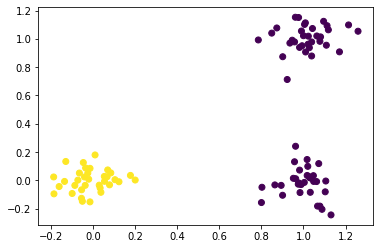

In [6]:
xs = X[:,0]
ys = X[:,1]

plt.scatter(xs, ys, c=y, cmap = "viridis")

## Build the Graph

## Form Optimization Problem

Define loss function

In [7]:
def probit(kvals, y, f):
	return -sum([log(norm.cdf(y[j]*f[j])) for j in kvals])

In [8]:
f = [1 for j in range(m)]

In [9]:
probit(knownvals, y, f)

3.8547970690419766

Define regularization

In [18]:
def regular(lamb,C_inv,f):
    f_T = np.array(f).T
    return lamb*f_T.dot(C_inv).dot(f)

In [15]:
tau = 1
alpha = 2
lamb = 1
C = np.linalg.matrix_power(((L + (tau**2)*np.eye(m))),-alpha)
C_inv = np.linalg.inv(C)

In [19]:
regular(1,C_inv,f)

101.99999999999982